#Forecasting Daily Price Direction

Main Steps:
1.   Load Datasets
2.   EDA & Preprocessing.
3.   Engineering Features:
  * ***y_label*** (Buy, sell, Hold) based on α
  * ***Technical Indicators***:
  • The Weighted Moving Average (WMA)
  • The Exponential Moving Average (EMA)
  • The simple moving average (SMA)
  • The Relatively Strength Index (RSI)
  • The average directional index (ADX)
  • The Commodity Channel Index (CCI)
  • The Rate-of-Change (ROC)
  • The Bollinger Band (BB)
  • The Moving Average Convergence Divergence
  (MACD)
  • The Moving Polynomial trending.
  * ***And Simple Technical Trading Rules***.
4. EDA again.
5. Preprocessing.
6. Implementing base paper model (CNN-GRU)
7. Improving accuracy.



In [ ]:
from google.colab import drive

## Packages, Libraries, Functions

In [ ]:
!pip install pandas-ta
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=8443d973cd518254c5b98e881d0c44b5d52b227b9e4fccee9f3a666e1961ed5f
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd

import pandas_ta as ta

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import keras
from tensorflow.keras.layers import BatchNormalization, Conv1D, Dropout, GRU, Flatten, Dense, LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor

import seaborn as sns;sns.set()
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import matplotlib.pyplot as plt
from matplotlib import cm


import time
import datetime, pytz
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
%matplotlib inline

In [ ]:
''' FUNCTIONS TO PLOT GRAPH GRAPHS'''


def plot_line(ldf,lst,title='',sec_id=None,size=[350,1000]):


    if(sec_id is not None):
        fig = make_subplots(specs=[[{"secondary_y": True}]])
    else:
        fig = go.Figure()

    if(len(lst) is not 1):
        ii=-1
        for i in lst:
            ii+=1
            if(sec_id is not None):
                fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[ii]],mode='lines',name=lst[ii],line=dict(width=2.0)),secondary_y=sec_id[ii])
            else:
                fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[ii]],mode='lines',name=lst[ii],line=dict(width=2.0)))
    else:
        fig.add_trace(go.Scatter(x=ldf.index, y=ldf[lst[0]],mode='lines',name=lst[0],line=dict(width=2.0)))

    fig.update_layout(height=size[0],width=size[1],template='plotly_white',title=title,
                          margin=dict(l=50,r=80,t=50,b=40));fig.show()

def plot_vsubplots(ldf,lst,title='',nplots=None,lw_id=None,size=[400,1000]):


    assert(nplots is not None)
    fig = make_subplots(rows=nplots,shared_xaxes=True)
    ii=-1
    for i in lst:
        ii+=1
        fig.add_trace(go.Scatter(x=ldf.index,y=ldf[lst[ii]], mode='lines'
        ,name=lst[ii],line=dict(width=lw_id[ii])), row=ii+1, col=1)

    fig.update_layout(height=size[0],width=size[1],template='plotly_white',title=title,
                          margin=dict(l=50,r=80,t=50,b=40));fig.show()

colours = ['tab:blue','tab:red','tab:green']
def plot_line2(ldf,lst,title=''):

    ii=-1
    plt.figure(figsize=(14,5))
    for i in lst:
        ii+=1
        ax = ldf[lst[ii]].plot(color=colours[ii],label=lst[ii],lw=1.5)
    plt.title(title)
    plt.legend();plt.show()

cmap = sns.diverging_palette(220, 10, as_cmap=True)

def corrMat(df,target='demand',figsize=(9,0.5),ret_id=False):

    corr_mat = df.corr().round(2);shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()

    if(ret_id is False):
        f, ax = plt.subplots(figsize=figsize)
        sns.heatmap(corr,vmin=-0.3,vmax=0.3,center=0,
                     cmap=cmap,square=False,lw=2,annot=True,cbar=False)
        plt.title(f'Feature Correlation to {target}')

    if(ret_id):
        return corr

def bar_plot(x, y,palette_len,title='Missing Values (%)', xlim = None, ylim = None,
             xticklabels = None, yticklabels = None,xlabel = None, ylabel = None,
             figsize = (10,4),axis_grid = 'y'):

    cmap = sns.color_palette("plasma")
    fig, ax = plt.subplots(figsize = figsize)
    plt.title(title,size = 15, fontweight = 'bold')

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')

    ax.spines['top'].set_visible(True);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)

    sns.barplot(x = x, y = y, edgecolor = 'black', ax = ax,
                palette = cmap)
    ax.set_xlim(xlim);ax.set_ylim(ylim)
    ax.set_xticklabels(xticklabels);ax.set_yticklabels(yticklabels)
    plt.xlabel(xlabel);plt.ylabel(ylabel)
    ax.grid(axis = axis_grid,ls='--',alpha = 0.9)
    plt.show()

def scatterPlot(xDF, yDF, algoName):

    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["Component 1","Component 2","Label"]
    g = sns.scatterplot(x="Component 1",y="Component 2",data=tempDF,hue="Label",
                        linewidth=0.5,alpha=0.5,s=15,edgecolor='k')
    plt.title(algoName);plt.legend()

    for i in ['top', 'right', 'bottom', 'left']:
        ax.spines[i].set_color('black')

    ax.spines['top'].set_visible(False);ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False);ax.spines['left'].set_visible(False)
    ax.grid(axis = 'both',ls='--',alpha = 0.9)
    plt.show()

def plot_history(history):
    fig = px.line(history.history, y=['loss', 'val_loss', 'accuracy', 'val_accuracy'], labels={'variable': 'Metric', 'value': 'Value'}, title='Training History')
    fig.show()

## Dataset

For this we'll be using GBP\USA historical data from [Investing.com](https://www.investing.com/currencies/gbp-usd-historical-data), dated from range
* Start: 01/01/2017
* End : 25/04/2023

This OHLCV dataset contains the following typical features which we expect OHLCV dataset:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#dataset path here

df = pd.read_csv('/content/drive/MyDrive/Colab/GBP_USD Historical Data.csv',
                 parse_dates=['Date'],) # specify the data type of the date column as string to avoid errors
df = df.sort_values(by='Date', ascending= False )
print(df.head())

        Date   Price    Open    High     Low    Vol. Change %
0 2023-04-25  1.2408  1.2480  1.2508  1.2386  91.39K   -0.59%
1 2023-04-24  1.2482  1.2439  1.2487  1.2409  96.86K    0.42%
2 2023-04-21  1.2430  1.2435  1.2449  1.2366  76.69K   -0.10%
3 2023-04-20  1.2443  1.2443  1.2469  1.2405  88.39K    0.04%
4 2023-04-19  1.2438  1.2428  1.2476  1.2392  67.83K    0.11%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1647 entries, 0 to 1646
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1647 non-null   datetime64[ns]
 1   Price     1647 non-null   float64       
 2   Open      1647 non-null   float64       
 3   High      1647 non-null   float64       
 4   Low       1647 non-null   float64       
 5   Vol.      1120 non-null   object        
 6   Change %  1647 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 102.9+ KB


In [ ]:
pd.set_option('display.precision',2)
df.describe()

,Price,Open,High,Low
count,1647.00,1647.00,1647.00,1647.00
mean,1.30,1.30,1.30,1.29
std,0.06,0.06,0.06,0.07
min,1.07,1.07,1.08,1.04
25%,1.25,1.25,1.25,1.24
50%,1.30,1.30,1.30,1.29
75%,1.34,1.34,1.34,1.34
max,1.43,1.43,1.44,1.43


In [ ]:
# Checking if null values are present or not
df['Price'].isnull().values.any(), df['Price'].isnull().sum().sum()

(False, 0)

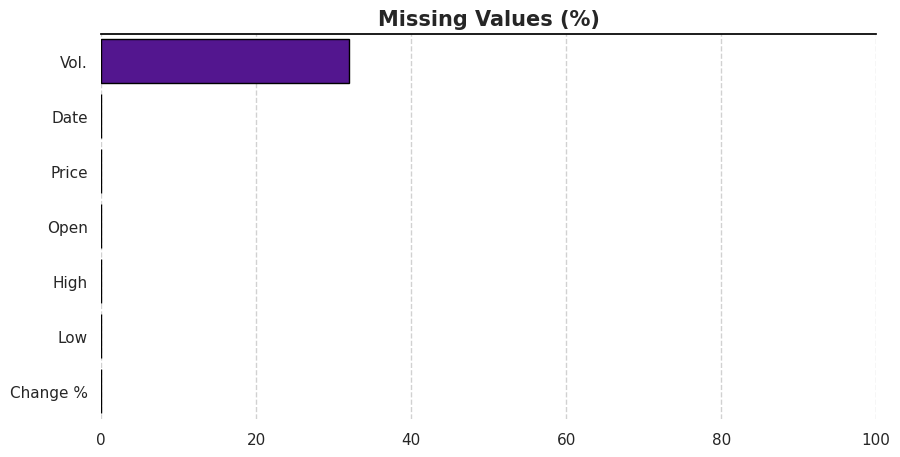

In [ ]:
NaN_values = (df.isnull().sum()/len(df)*100).sort_values(ascending = False)

# Plot missing data
bar_plot(x = NaN_values,y = NaN_values.index,palette_len = NaN_values.index,
         xlim = (0,100),xticklabels = range(0,101,20),yticklabels = NaN_values.index,
         figsize = (10,5), axis_grid = 'x')

Vol. column\feature will not be used, so we dont have to fill or drop the missing rows.

## Feature Engineering

### Part 1: The Target Variable

"In this article, we are trying to
predict the next price direction, but the price feature in the
collected dataset is a continuous variable. To formulate the
problem as a classification problem, we created a new variable
that indicates the decision as a signal (Buy Signal, Sell Signal,
and Hold Signal). First, we determinate a positive number as
a threshold called α. the goal is to compare this parameter
with the log return. When the log return of the current day is
inferior to -α, it indicates that it is an uptrend, so it is a SELL
signal, and when the log return is superior to α , it indicates
that’s a downtrend, so it is a BUY signal; otherwise, it is a
HOLD signal. However, in this case, the type of this variable
is categorical; that is why We have converted this feature using
one-hot encoding, so it can be provided to our algorithms and
fit our model. The `threshold (α ): α is between 0 and 1.` .
Due to the forte fluctuation of the markets, there will always
be a difference between the prices of the current and the next
day. However, not each movement of the prices should be an
uptrend or downtrend; the operation costs of buying or selling
could be more expensive than the returns. To reduce the noise
and identify the real trends, we compare the log-returns with a
threshold called α to avoid the problem of unbalanced classes
in the datasets, which happen in our case when α is too much
low or too high. However, balancing the dataset artificially will
affect the sequential datasets. We decided to run our algorithm
using different thresholds starting from `zero` (which led us to
a binary classification problem) to `0.001`. when we go with
a threshold higher than 0.001, we are stuck with unbalanced
datasets"


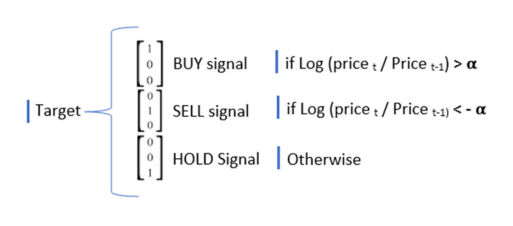

In [ ]:
# Set the threshold value
aplha_threshold = [0, 0.0001, 0.0002, 0.0003, 0.0005, 0.001]

In [ ]:
dataset = df.copy()

# Calculate the log returns
dataset['log_return'] = np.log(dataset.Price) - np.log(dataset.Price.shift(1))

In [ ]:
for alpha in aplha_threshold:

  # Create the signal variable using the threshold value
  dataset[f'signal_{str(alpha)}'] = np.where(dataset['log_return'] > alpha, 'Buy',
                    np.where(dataset['log_return'] < -alpha, 'Sell', 'Hold'))

new columns has been added containing (Hold, Sell and buy) values according to different thersholds.

```
['signal_0', 'signal_0.0001', 'signal_0.0002', 'signal_0.0003', 'signal_0.0005', 'signal_0.001']
```
These columns will act as our different `y` values.

Lets counts there radio:

In [ ]:
dataset[['signal_0', 'signal_0.0001', 'signal_0.0002', 'signal_0.0003', 'signal_0.0005', 'signal_0.001']]

,signal_0,signal_0.0001,signal_0.0002,signal_0.0003,signal_0.0005,signal_0.001
0,Hold,Hold,Hold,Hold,Hold,Hold
1,Buy,Buy,Buy,Buy,Buy,Buy
2,Sell,Sell,Sell,Sell,Sell,Sell
3,Buy,Buy,Buy,Buy,Buy,Buy
4,Sell,Sell,Sell,Sell,Hold,Hold
...,...,...,...,...,...,...
1642,Buy,Buy,Buy,Buy,Buy,Buy
1643,Buy,Buy,Buy,Buy,Buy,Buy
1644,Sell,Sell,Sell,Sell,Sell,Sell
1645,Sell,Sell,Sell,Sell,Sell,Sell


In [ ]:
print(f'{dataset.signal_0.value_counts()}')
print(dataset['signal_0.0001'].value_counts())
print(dataset['signal_0.0002'].value_counts())
print(dataset['signal_0.0003'].value_counts())
print(dataset['signal_0.0005'].value_counts())
print(dataset['signal_0.001'].value_counts())

Sell    826
Buy     808
Hold     13
Name: signal_0, dtype: int64
Sell    813
Buy     796
Hold     38
Name: signal_0.0001, dtype: int64
Sell    805
Buy     787
Hold     55
Name: signal_0.0002, dtype: int64
Sell    790
Buy     772
Hold     85
Name: signal_0.0003, dtype: int64
Sell    753
Buy     738
Hold    156
Name: signal_0.0005, dtype: int64
Sell    691
Buy     678
Hold    278
Name: signal_0.001, dtype: int64


### Part 2: Technical Indicators
The collected dataset consists only
of five features, Open, High, Low, close, and Volume (OLHCV). To add additional information to the original datasets,
we created an algorithm that generates new features based on
mathematical calculations, this type of feature is known as
`“technical indicators”`.
In general, technical analysts use technical indicators to
understand and analyze the price movement in a specific
market and avoid emotional investments. However, technical
indicators give an idea of where the price might go next in a
given market at a specific time.
In this research, we have used the most-used technical
indicators:
* The Weighted Moving Average (WMA)
* The Exponential Moving Average (EMA)
* The simple moving average (SMA)
* The Relatively Strength Index (RSI)
* The average directional index (ADX)
* The Commodity Channel Index (CCI)
* The Rate-of-Change (ROC)
* The Bollinger Band (BB)
* The Moving Average Convergence Divergence
(MACD)
* The Moving Polynomial trending

Technical analysts may get different results depending on the
chosen parameters, even using the same technical indicators.
So, to train our model with the best parameters of technical
indicators, in our strategy, we generate each technical indicator
on multiple periods, as shown in Table I. The goal is for our
algorithm to identify the best subset of relevant characteristics
predictors and determine the optimal combination of parameters (features).

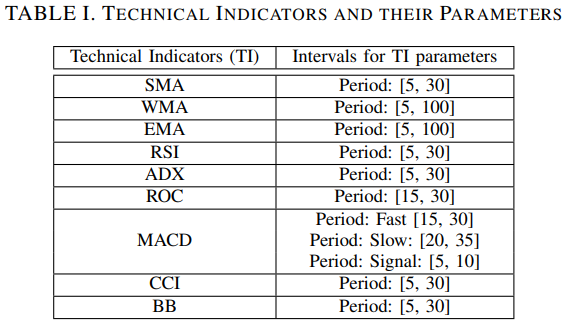

In [ ]:
dataset_2 = dataset.copy()

In [ ]:
# Define the intervals for TI parameters
sma_periods = [5, 30]
wma_periods = [5, 100]
ema_periods = [5, 100]
rsi_periods = [5, 30]
adx_periods = [5, 30]
roc_periods = [15, 30]
fast_periods = [15, 30]
macd_slow_periods = [20, 35]
macd_signal_periods = [5, 10]
cci_periods = [5, 30]
bb_periods = [5, 30]

In [ ]:
# Calculate the Technical Indicators for each interval
for p in sma_periods:
    dataset_2[f'sma_{p}'] = ta.sma(dataset_2['Price'], length=p)

for p in wma_periods:
    dataset_2[f'wma_{p}'] = ta.wma(dataset_2['Price'], length=p)

for p in ema_periods:
    dataset_2[f'ema_{p}'] = ta.ema(dataset_2['Price'], length=p)

for p in rsi_periods:
    dataset_2[f'rsi_{p}'] = ta.rsi(dataset_2['Price'], length=p)

for p in adx_periods:
    adx = ta.adx(dataset_2['High'],
                                   dataset_2['Low'],
                                   dataset_2['Price'], length=p)
    dataset_2 = dataset_2.join(adx)

for p in roc_periods:
    dataset_2[f'roc_{p}'] = ta.roc(dataset_2['Price'], length=p)

for p in fast_periods:
    dataset_2[f'fast_{p}'] = ta.ema(dataset_2['Price'], length=p)

for p in macd_slow_periods:
    dataset_2[f'macd_slow_{p}'] = ta.ema(dataset_2['Price'], length=p)

for p in macd_signal_periods:
    dataset_2[f'macd_signal_{p}'] = ta.ema(dataset_2['Price'], length=p)

for p in cci_periods:
    dataset_2[f'cci_{p}'] = ta.cci(dataset_2['High'], df['Low'], df['Price'], length=p)

for p in bb_periods:
    bbands = ta.bbands(dataset_2['Price'], length=p)
    dataset_2 = dataset_2.join(bbands)

In [ ]:
dataset_2.head()

,Date,Price,Open,High,Low,Vol.,Change %,log_return,signal_0,signal_0.0001,...,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,BBL_30_2.0,BBM_30_2.0,BBU_30_2.0,BBB_30_2.0,BBP_30_2.0
0,2023-04-25,1.24,1.25,1.25,1.24,91.39K,-0.59%,NaN,Hold,Hold,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-04-24,1.25,1.24,1.25,1.24,96.86K,0.42%,5.95e-03,Buy,Buy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-04-21,1.24,1.24,1.24,1.24,76.69K,-0.10%,-4.17e-03,Sell,Sell,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-04-20,1.24,1.24,1.25,1.24,88.39K,0.04%,1.05e-03,Buy,Buy,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-04-19,1.24,1.24,1.25,1.24,67.83K,0.11%,-4.02e-04,Sell,Sell,...,1.24,1.24,1.25,0.77,0.48,NaN,NaN,NaN,NaN,NaN


### Part 3:  Simple Technical Trading Rules
In general, for technical analysts generating technical indicators is not enough
to build a trading strategy; to reach their goal, they convert
technical indicators into trading rules. in our research, to enrich
our datasets and get the best results, we will use some simple
trading rules such as:

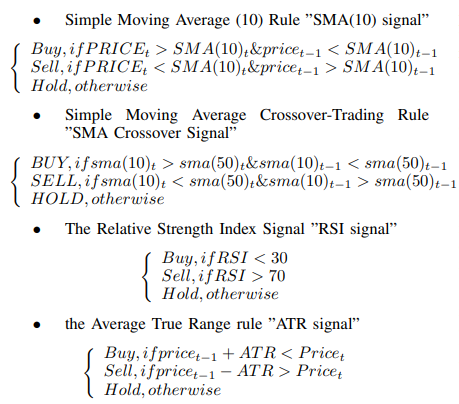

In [ ]:
dataset_3 = dataset_2.copy()

In [ ]:
# Add indicators, using data from before
dataset_3.ta.sma(close='Price', length=10, append=True, )

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1642    1.22
1643    1.22
1644    1.22
1645    1.22
1646    1.22
Name: SMA_10, Length: 1647, dtype: float64

In [ ]:
def sma_10_signal(data):

    # Apply trading rule
    data['signal_sma_10'] = np.where((data['Price'] > data['SMA_10']) &
                                (data['Price'].shift(1) < data['SMA_10'].shift(1)), 'BUY',
                                np.where((data['Price'] < data['SMA_10']) &
                                         (data['Price'].shift(1) > data['SMA_10'].shift(1)), 'SELL', 'HOLD'))
    return data


In [ ]:
dataset_3 = sma_10_signal(dataset_3)

In [ ]:
def sma_crossover_signal(data):
    # Calculate 10-day and 50-day simple moving averages
    data['SMA_50'] = data['Price'].rolling(window=50).mean()

    # Apply trading rule
    data['signal_sma_crossover'] = np.where((data['SMA_10'] > data['SMA_50']) &
                                (data['SMA_10'].shift(1) < data['SMA_50'].shift(1)), 'BUY',
                                np.where((data['SMA_10'] < data['SMA_50']) &
                                         (data['SMA_10'].shift(1) > data['SMA_50'].shift(1)), 'SELL', 'HOLD'))
    return data

In [ ]:
dataset_3 = sma_crossover_signal(dataset_3)

In [ ]:
dataset_3.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %',
       'log_return', 'signal_0', 'signal_0.0001', 'signal_0.0002',
       'signal_0.0003', 'signal_0.0005', 'signal_0.001', 'sma_5', 'sma_30',
       'wma_5', 'wma_100', 'ema_5', 'ema_100', 'rsi_5', 'rsi_30', 'ADX_5',
       'DMP_5', 'DMN_5', 'ADX_30', 'DMP_30', 'DMN_30', 'roc_15', 'roc_30',
       'fast_15', 'fast_30', 'macd_slow_20', 'macd_slow_35', 'macd_signal_5',
       'macd_signal_10', 'cci_5', 'cci_30', 'BBL_5_2.0', 'BBM_5_2.0',
       'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'BBL_30_2.0', 'BBM_30_2.0',
       'BBU_30_2.0', 'BBB_30_2.0', 'BBP_30_2.0', 'SMA_10', 'signal_sma_10',
       'SMA_50', 'signal_sma_crossover'],
      dtype='object')

In [ ]:
dataset_3['signal_rsi'] = np.where(dataset_3['rsi_5'] < 30, 'BUY',
                                np.where(dataset_3['rsi_5'] > 70, 'SELL', 'HOLD'))

In [ ]:
dataset_3['atr_5'] = ta.atr(dataset_3['High'],
                            dataset_3['Low'],
                            dataset_3['Price'],
                            length = 5 )

In [ ]:
dataset_3['signals_atr'] = np.where(
      dataset_3['Price'] > (dataset_3['Price'].shift(1) + dataset_3['atr_5']), 'BUY',
                              np.where(dataset_3['Price'] < (dataset_3['Price'].shift(1) - dataset_3['atr_5']),
                                       'SELL', 'HOLD'))

In [ ]:
dataset_3.head()

,Date,Price,Open,High,Low,Vol.,Change %,log_return,signal_0,signal_0.0001,...,BBU_30_2.0,BBB_30_2.0,BBP_30_2.0,SMA_10,signal_sma_10,SMA_50,signal_sma_crossover,signal_rsi,atr_5,signals_atr
0,2023-04-25,1.24,1.25,1.25,1.24,91.39K,-0.59%,NaN,Hold,Hold,...,NaN,NaN,NaN,NaN,HOLD,NaN,HOLD,HOLD,NaN,HOLD
1,2023-04-24,1.25,1.24,1.25,1.24,96.86K,0.42%,5.95e-03,Buy,Buy,...,NaN,NaN,NaN,NaN,HOLD,NaN,HOLD,HOLD,NaN,HOLD
2,2023-04-21,1.24,1.24,1.24,1.24,76.69K,-0.10%,-4.17e-03,Sell,Sell,...,NaN,NaN,NaN,NaN,HOLD,NaN,HOLD,HOLD,NaN,HOLD
3,2023-04-20,1.24,1.24,1.25,1.24,88.39K,0.04%,1.05e-03,Buy,Buy,...,NaN,NaN,NaN,NaN,HOLD,NaN,HOLD,HOLD,NaN,HOLD
4,2023-04-19,1.24,1.24,1.25,1.24,67.83K,0.11%,-4.02e-04,Sell,Sell,...,NaN,NaN,NaN,NaN,HOLD,NaN,HOLD,HOLD,NaN,HOLD


In [ ]:
dataset_3.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %',
       'log_return', 'signal_0', 'signal_0.0001', 'signal_0.0002',
       'signal_0.0003', 'signal_0.0005', 'signal_0.001', 'sma_5', 'sma_30',
       'wma_5', 'wma_100', 'ema_5', 'ema_100', 'rsi_5', 'rsi_30', 'ADX_5',
       'DMP_5', 'DMN_5', 'ADX_30', 'DMP_30', 'DMN_30', 'roc_15', 'roc_30',
       'fast_15', 'fast_30', 'macd_slow_20', 'macd_slow_35', 'macd_signal_5',
       'macd_signal_10', 'cci_5', 'cci_30', 'BBL_5_2.0', 'BBM_5_2.0',
       'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'BBL_30_2.0', 'BBM_30_2.0',
       'BBU_30_2.0', 'BBB_30_2.0', 'BBP_30_2.0', 'SMA_10', 'signal_sma_10',
       'SMA_50', 'signal_sma_crossover', 'signal_rsi', 'atr_5', 'signals_atr'],
      dtype='object')

### OneHot Encoding

In [ ]:
dataset_3['signal_sma_crossover'].value_counts()

HOLD    1611
BUY       18
SELL      18
Name: signal_sma_crossover, dtype: int64

In [ ]:
# Encode the signal variable using one-hot encoding
encoder = OneHotEncoder()
signal_encoded = encoder.fit_transform(dataset_3['signal_sma_10'].values.reshape(-1,1)).toarray()

# Add the encoded signal variable to the dataset
signal_labels = ['signal_sma_10_Buy', 'signal_sma_10_Hold', 'signal_sma_10_Sell']
signal_encoded_df = pd.DataFrame(signal_encoded, columns=signal_labels)
dataset_3 = pd.concat([dataset_3, signal_encoded_df], axis=1)

In [ ]:
encoder = OneHotEncoder()
signal_encoded = encoder.fit_transform(
    dataset_3['signal_sma_crossover'].values.reshape(-1,1)).toarray()

# Add the encoded signal variable to the dataset
signal_labels = ['signal_sma_crossover_Buy', 'signal_sma_crossover_Hold',
                 'signal_sma_crossover_Sell']

signal_encoded_df = pd.DataFrame(signal_encoded, columns=signal_labels)
dataset_3 = pd.concat([dataset_3, signal_encoded_df], axis=1)

In [ ]:
encoder = OneHotEncoder()
signal_encoded = encoder.fit_transform(
    dataset_3['signals_atr'].values.reshape(-1,1)).toarray()

# Add the encoded signal variable to the dataset
signal_labels = ['signals_atr_Buy', 'signals_atr_Hold',
                 'signals_atr_Sell']

signal_encoded_df = pd.DataFrame(signal_encoded, columns=signal_labels)
dataset_3 = pd.concat([dataset_3, signal_encoded_df], axis=1)

In [ ]:
encoder = OneHotEncoder()
signal_encoded = encoder.fit_transform(
    dataset_3['signal_0'].values.reshape(-1,1)).toarray()

# Add the encoded signal variable to the dataset
signal_labels = ['signal_0_Buy', 'signal_0_Hold',
                 'signal_0_Sell']

signal_encoded_df = pd.DataFrame(signal_encoded, columns=signal_labels)
dataset_3 = pd.concat([dataset_3, signal_encoded_df], axis=1)

In [ ]:
dataset_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1647 entries, 0 to 1646
Data columns (total 67 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       1647 non-null   datetime64[ns]
 1   Price                      1647 non-null   float64       
 2   Open                       1647 non-null   float64       
 3   High                       1647 non-null   float64       
 4   Low                        1647 non-null   float64       
 5   Vol.                       1120 non-null   object        
 6   Change %                   1647 non-null   object        
 7   log_return                 1646 non-null   float64       
 8   signal_0                   1647 non-null   object        
 9   signal_0.0001              1647 non-null   object        
 10  signal_0.0002              1647 non-null   object        
 11  signal_0.0003              1647 non-null   object        
 12  signal

In [ ]:
corr_matrix = dataset_3.corr()

In [ ]:
corr_matrix

,Price,Open,High,Low,log_return,sma_5,sma_30,wma_5,wma_100,ema_5,...,signal_sma_10_Sell,signal_sma_crossover_Buy,signal_sma_crossover_Hold,signal_sma_crossover_Sell,signals_atr_Buy,signals_atr_Hold,signals_atr_Sell,signal_0_Buy,signal_0_Hold,signal_0_Sell
Price,1.00e+00,9.94e-01,9.97e-01,9.97e-01,5.78e-02,9.92e-01,9.46e-01,9.96e-01,8.85e-01,9.95e-01,...,6.84e-03,2.17e-03,-5.01e-03,4.87e-03,2.55e-02,-2.42e-02,9.17e-03,3.45e-02,3.67e-02,-4.10e-02
Open,9.94e-01,1.00e+00,9.97e-01,9.97e-01,6.20e-02,9.85e-01,9.40e-01,9.89e-01,8.79e-01,9.88e-01,...,4.74e-03,-1.01e-03,-2.32e-03,4.28e-03,2.20e-02,-2.51e-02,1.36e-02,3.63e-02,4.10e-02,-4.35e-02
High,9.97e-01,9.97e-01,1.00e+00,9.96e-01,6.03e-02,9.89e-01,9.44e-01,9.93e-01,8.84e-01,9.92e-01,...,6.93e-03,1.42e-03,-4.35e-03,4.71e-03,2.33e-02,-2.51e-02,1.24e-02,3.64e-02,3.88e-02,-4.33e-02
Low,9.97e-01,9.97e-01,9.96e-01,1.00e+00,5.94e-02,9.89e-01,9.43e-01,9.93e-01,8.81e-01,9.92e-01,...,5.65e-03,6.80e-04,-3.08e-03,3.65e-03,2.36e-02,-2.41e-02,1.08e-02,3.41e-02,3.88e-02,-4.09e-02
log_return,5.78e-02,6.20e-02,6.03e-02,5.94e-02,1.00e+00,-3.50e-02,-4.59e-02,-1.91e-02,-4.96e-02,-1.85e-02,...,-3.21e-01,-6.04e-03,1.55e-02,-1.58e-02,2.53e-01,3.58e-02,-2.83e-01,7.33e-01,9.58e-05,-7.33e-01
sma_5,9.92e-01,9.85e-01,9.89e-01,9.89e-01,-3.50e-02,1.00e+00,9.60e-01,9.99e-01,9.01e-01,9.99e-01,...,3.11e-02,-6.51e-03,-3.49e-03,1.14e-02,2.68e-03,-2.57e-02,3.23e-02,-3.43e-02,4.47e-02,2.66e-02
sma_30,9.46e-01,9.40e-01,9.44e-01,9.43e-01,-4.59e-02,9.60e-01,1.00e+00,9.57e-01,9.68e-01,9.62e-01,...,1.05e-02,-3.51e-02,3.14e-03,3.07e-02,5.06e-03,-2.97e-02,3.55e-02,-4.67e-02,4.71e-02,3.86e-02
wma_5,9.96e-01,9.89e-01,9.93e-01,9.93e-01,-1.91e-02,9.99e-01,9.57e-01,1.00e+00,8.97e-01,1.00e+00,...,2.83e-02,-2.09e-03,-4.83e-03,8.88e-03,5.99e-03,-2.55e-02,2.90e-02,-2.25e-02,4.43e-02,1.50e-02
wma_100,8.85e-01,8.79e-01,8.84e-01,8.81e-01,-4.96e-02,9.01e-01,9.68e-01,8.97e-01,1.00e+00,9.03e-01,...,1.88e-02,-1.18e-02,-1.06e-02,2.61e-02,1.74e-02,-3.97e-02,3.74e-02,-5.34e-02,3.70e-02,4.69e-02
ema_5,9.95e-01,9.88e-01,9.92e-01,9.92e-01,-1.85e-02,9.99e-01,9.62e-01,1.00e+00,9.03e-01,1.00e+00,...,2.58e-02,-6.34e-03,-3.78e-03,1.17e-02,6.20e-03,-2.56e-02,2.90e-02,-2.25e-02,4.51e-02,1.48e-02


<Axes: >

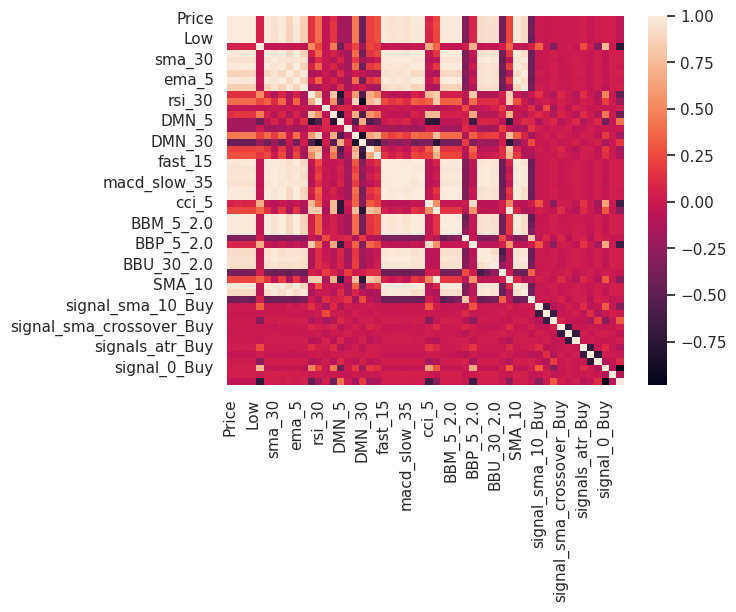

In [ ]:
# Plot the correlation matrix using seaborn heatmap
sns.heatmap(corr_matrix)

### Final dataset

After all the feature Engineering we have left with the following features values:



```
['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %',
       'log_return', 'signal_0', 'signal_0.0001', 'signal_0.0002',
       'signal_0.0003', 'signal_0.0005', 'signal_0.001', 'sma_5', 'sma_30',
       'wma_5', 'wma_100', 'ema_5', 'ema_100', 'rsi_5', 'rsi_30', 'ADX_5',
       'DMP_5', 'DMN_5', 'ADX_30', 'DMP_30', 'DMN_30', 'roc_15', 'roc_30',
       'fast_15', 'fast_30', 'macd_slow_20', 'macd_slow_35', 'macd_signal_5',
       'macd_signal_10', 'cci_5', 'cci_30', 'BBL_5_2.0', 'BBM_5_2.0',
       'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'BBL_30_2.0', 'BBM_30_2.0',
       'BBU_30_2.0', 'BBB_30_2.0', 'BBP_30_2.0', 'SMA_10', 'signal_sma_10',
       'SMA_50', 'signal_sma_crossover', 'signal_rsi', 'atr_5', 'signals_atr',
       'signal_sma_10_Buy', 'signal_sma_10_Hold', 'signal_sma_10_Sell',
       'signal_sma_crossover_Buy', 'signal_sma_crossover_Hold',
       'signal_sma_crossover_Sell', 'signals_atr_Buy', 'signals_atr_Hold',
       'signals_atr_Sell']
```



## EDA

In [ ]:
dataset_3= dataset_3.set_index('Date')

In [ ]:
plot_vsubplots(dataset_3,['Price','signal_0'],
               title='Weighted Price & Signal Fluctional in Training Data',
               nplots=2,
               lw_id=[2,0.4],
               size=[500,1000])

In [ ]:
# Data Periods used in Notebook
plot_period = slice('2021-1-7','2021-1-8') # Selection Plot Period for visualisation only
data_period = slice('2021-7-6','2021-9-14') # Select Data Period for Analysis

In [ ]:
ROC = ['roc_15', 'roc_30',]
plot_line(dataset_3.loc['2022-04-25':, ROC],ROC,
          title='Rate-of-Change (ROC)')

In [ ]:
WMA = [ 'wma_5', 'wma_100',]
plot_line(dataset_3.loc['2022-04-25':, WMA],WMA,
          title=' Weighted Moving Average')

In [ ]:
MACD = ['fast_15', 'fast_30', 'macd_slow_20', 'macd_slow_35', 'macd_signal_5',
       'macd_signal_10']
plot_line(dataset_3.loc['2022-04-25':, MACD],MACD,
          title=' Moving Average Convergence Divergence (MACD)')

In [ ]:
# Visualise Training Set Target Variable Related Features

lst_CCI = ['cci_5','cci_30']
plot_line(dataset_3.loc['2022-04-25':, lst_CCI],lst_CCI,
          title='Commodity Channel Index (window=5,30)')

In [ ]:
# Visualise Training Set Target Variable Related Features

lst_MAV = ['sma_5','sma_30','signal_0']
ldf = dataset_3.loc['2022-04-25': , lst_MAV]
plot_line(ldf,lst_MAV,
          title='SM5, SMA30 & Signal created from Closing Price',
          sec_id=[False,False,True])

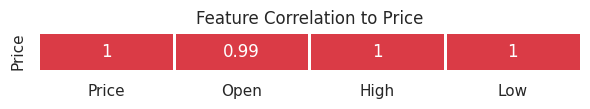

In [ ]:
corrMat(df.drop(['Vol.', 'Change %'], axis = 1).set_index('Date'),
        'Price',figsize=(7,0.5)) # Baseline Dataframe feature correlation to Signal

In [ ]:
lst_SMA = ['sma_5','sma_30']
plot_line(dataset_3.loc['2022-04-25':, lst_SMA],lst_SMA,
          title='simple moving average (window=5,30)')

In [ ]:
lst_EMA = ['ema_5','ema_100']
plot_line(dataset_3.loc['2022-04-25':, lst_EMA], lst_EMA,
          title='Exponential moving average (window=5,100)')

In [ ]:
lst_RSI = ['rsi_5','rsi_30']
plot_line(dataset_3.loc['2022-04-25':, lst_RSI],lst_RSI,
          title='Relative Strength Index (window=5,30)')

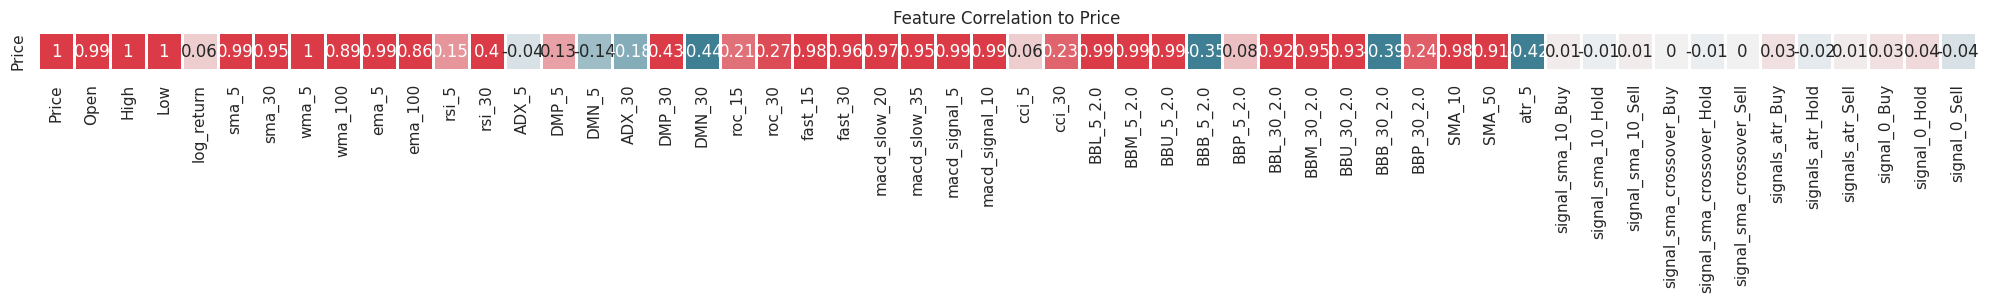

In [ ]:
corrMat(dataset_3.select_dtypes(exclude='object'),
        'Price',figsize=(25,0.5)) # Baseline Dataframe feature correlation to Signal

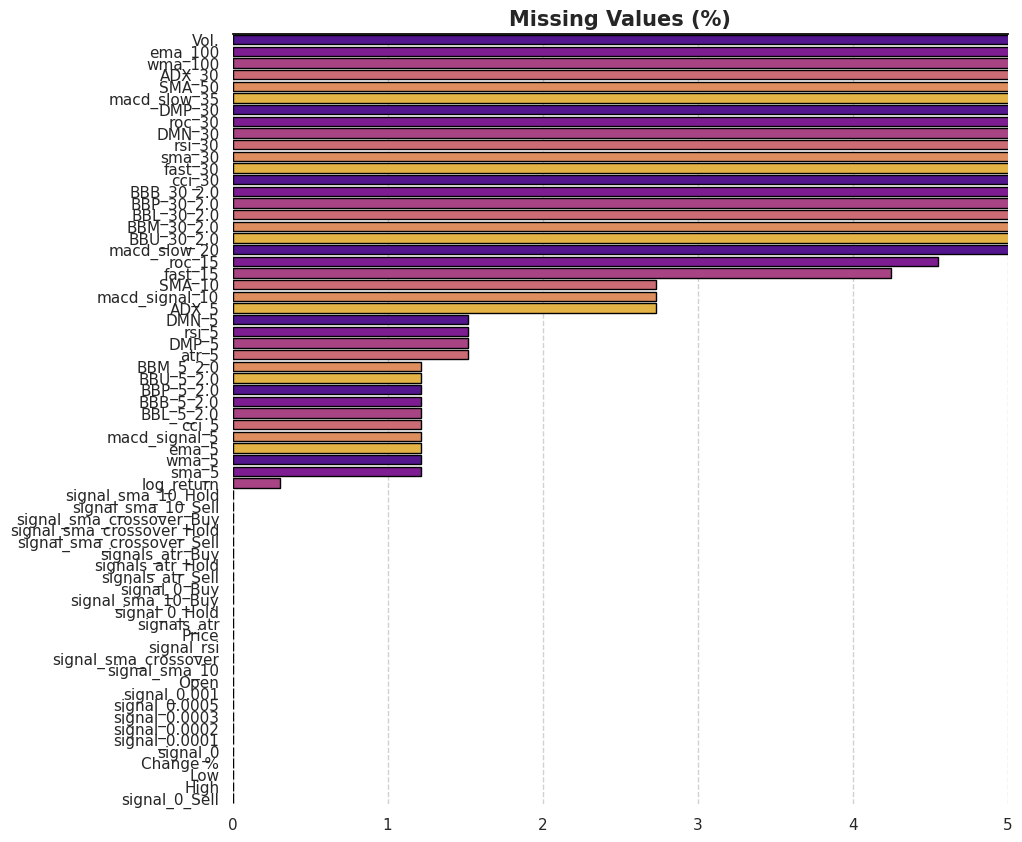

In [ ]:
NaN_values = (dataset_3.isnull().sum() / len(dataset_3) * 100).sort_values(ascending = False)
bar_plot(x = NaN_values,y = NaN_values.index,palette_len = NaN_values.index,
         xlim = (0,1),xticklabels = range(0,10),yticklabels = NaN_values.index,
         figsize = (10,10), axis_grid = 'x')

In [ ]:
dataset_4 = dataset_3.copy()

In [ ]:
dataset_4 = dataset_4.dropna()

## Models Implementation

We'll try different models with different alpha thresholds and sliding window size.

1.   Model: CNN + GRU
    *  `α = 0 & window size [inputs] = 1[31, 1]`
2.   List item



### Preprocessing:

1. X or input columns will be the same for all the experiments but
y will change so

2. Dropped few columns too like volumn, chnage % and Non-OneHot encoded columns.

In [ ]:
input_cols = ['Price', 'Open', 'High', 'Low',
              'sma_5', 'sma_30', 'wma_5', 'wma_100', 'ema_5',
              'ema_100', 'rsi_5', 'rsi_30', 'ADX_5', 'DMP_5', 'DMN_5', 'ADX_30',
              'DMP_30', 'DMN_30', 'roc_15', 'roc_30', 'fast_15', 'fast_30',
              'macd_slow_20', 'macd_slow_35', 'macd_signal_5', 'macd_signal_10',
              'cci_5', 'cci_30', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0',
              'BBP_5_2.0', 'BBL_30_2.0', 'BBM_30_2.0', 'BBU_30_2.0', 'BBB_30_2.0',
              'BBP_30_2.0', 'SMA_10', 'SMA_50',
              'atr_5', 'signal_sma_10_Buy', 'signal_sma_10_Hold',
              'signal_sma_10_Sell', 'signal_sma_crossover_Buy', 'signal_sma_crossover_Hold',
              'signal_sma_crossover_Sell', 'signals_atr_Buy', 'signals_atr_Hold',
              'signals_atr_Sell']

In [ ]:
def window(time_series, seq_length, y_col):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :-1]
        _y = time_series[i + seq_length, [y_col]]  # Next value in specified column
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

Creating a ftn to do all the experiments (combination of alpha and window_size)
which will be:

*   `α = [0.0, 0.0001, 0.0002, 0.0003, 0.0005, 0.001]`
*   `window_size = [1, 2, 3, 4, 5, 6, 10, 15, 20]`



**Parameters**
`α = 0 & window size [inputs] = 1[31, 1]`


In [ ]:
def generate_dataloaders_ws(data, alpha, window_size):
  """
    Generates train and validation datasets from the given data, alpha value, and window size.

    Parameters:
    data (pandas.DataFrame): The data to use for generating the datasets.
    alpha (float): The alpha value to use for encoding the output sequence.
    window_size (int): The size of the sliding window to use for generating the input and output sequences.

    Returns:
    train_data (tf.data.Dataset): The training dataset.
    valid_data (tf.data.Dataset): The validation dataset.
    """
  alpha_list = {0.0 : 'signal_0', 0.0001 : 'signal_0.0001', 0.0002 : 'signal_0.0002',
           0.0003 : 'signal_0.0003', 0.0005 : 'signal_0.0005', 0.001 : 'signal_0.001'}

  output_col = alpha_list[alpha]
  # Convert the dataframe to a numpy array
  data = data[input_cols + [output_col]].to_numpy()

  # Generate the input and output sequences
  X, y = window(data, window_size, -1)

  # Split radio 80:20 (based on the amount of the dataset)
  X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    shuffle = False,
                                                    random_state=0)
  label_encoder = LabelEncoder()
  y_train = label_encoder.fit_transform(y_train)
  y_test = label_encoder.fit_transform(y_test)

  X_train = X_train.astype(np.float32)
  X_test = X_test.astype(np.float32)

  train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
  valid_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

  return train_data, valid_data

In [ ]:
def exp_aplha_ws(data, model, α, window_size, path):
  """
    Runs an experiments using the given data and model
    with the specified alpha and window_size.
    This ftn will also write a .txt file '{path}_α_{aplha}_ws_[50_{window_size}]'
    to write the last epochs results and will also save training history in png
    format.

    Parameters:
    data (list): The data to use for training and validation.
    model (callable): The model to use for training and validation.
    α (float): The value of alpha to use for the experiment.
    window_size (int): The size of the sliding window to use for the experiment.
    path (str): The path to the directory where the experiment results will be saved.

    Returns:
    history (object): The training history of the model.
    model (callable): The trained model.
    """
  aplha = α
  window_size = window_size

  filename = str(f'{path}_α_{aplha}_ws_[50_{window_size}]')
  png_path = os.path.join(path, 'history_graphs')
  csv_path = os.path.join(path, 'csv_logger', filename + '.csv')

  train_ds, val_ds = generate_dataloaders_ws(data, alpha, window_size)

  history, model = model(train_ds, val_ds, csv_path)

  lastTrainLoss = round(history.history['loss'][-1], 2)
  lastValLoss = round(history.history['val_loss'][-1], 2)

  lastTrainAccuracy = round(history.history['accuracy'][-1], 2)
  lastvalAccuracy = round(history.history['val_accuracy'][-1], 2)

  if not os.path.exists(f"{png_path}/{filename}.png"):
    fig = px.line(history.history, y=['loss', 'val_loss', 'accuracy', 'val_accuracy'],
                  labels={'variable': 'Metric', 'value': 'Value'}, title='Training History')
    fig.write_image(f"{png_path}/{filename}.png")

  with open(f"{path}/{path}_all_results.txt", 'w') as file:
    file.write(f'\nExperiment number 0:\n Alpha = {alpha}, Window_size = {window_size}')
    file.write(f'\nlastTrainLoss = {str(lastTrainLoss)}, lastValLoss = {str(lastValLoss)} \n')
    file.write(f'lastTrainAccuracy = {str(lastTrainAccuracy)}, lastvalAccuracy = {str(lastvalAccuracy)} \n')

  return history, model

### Model 1 CNN + GRU

- the first layer is the input layer; it takes a two-dimensional
matrix as input; the number of rows is the same number of
days to look back. Each row represents the observation of all
variables on a specific day. The number of variables determines
the number of columns; each column represents the values of
a specific variable on the days to look back.
- the second layer is the convolutional layer, it is fed
directly by the input layer; it looks for features by sliding
multiple filters over the input matrix to recognize patterns.
- the third layer is the GRU layer; it is implemented on
many-to-one architecture, as shown in Fig. 4 because the goal
of our model is to predict the next day’s price direction, not
multiple days. This layer is added to deal with the sequential
data nature.
- The last layer is the dense layers/output layer, reduce
the number of features and get one decision (BUY, SELL or
HOLD).


In [ ]:
def model_CNN_GRU_training(train_data, valid_data, filename, epochs = 50):

  csv_logger = tf.keras.callbacks.CSVLogger(
                  filename, separator=',', append=False
                )

  # Creating the model
  model = tf.keras.Sequential([
      tf.keras.layers.Conv1D(filters = 32, kernel_size = 3, padding='same', activation='relu'),
      # tf.keras.layers.MaxPooling1D(pool_size = 2),
      tf.keras.layers.GRU(64, return_sequences = True),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(3, activation='softmax')
  ])

  model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

  history = model.fit(train_data, epochs = epochs, validation_data=valid_data,
                      shuffle=False, callbacks=[csv_logger] )

  return history, model

In [ ]:
α = [0.0, 0.0001, 0.0002, 0.0003, 0.0005, 0.001]
window_sizes = [1, 2, 3, 4, 5, 6, 10, 15, 20]

classes = {'Buy':0, 'Hold':1, 'Sell':2}
classes_list = [0, 1, 2]

In [ ]:
# path to the output folder where results will be stored. Please change the
# path if you want to store output in another place
Exp_output_path = 'Exp_CNN_GRU'

try:
  os.mkdir(os.path.join(Exp_output_path))
  os.mkdir(os.path.join(Exp_output_path ,'csv_logger'))
  os.mkdir(os.path.join(Exp_output_path ,'history_graphs'))
except:
  pass

In [ ]:
for i, alpha in enumerate(α, start=1):
  for window_size in window_sizes:
    print(f'\nExperiment number {i}:\n Alpha = {alpha}, Window_size = {window_size}')
    _history, _model = exp_aplha_ws(dataset_4,
                                    model_CNN_GRU_training,
                                    alpha,
                                    window_size,
                                    Exp_output_path) #Add the path/folder_name

Görüntülenen çıkış son 5000 satıra kısaltıldı.
26/26 [==============================] - 0s 7ms/step - loss: 0.5674 - accuracy: 0.7155 - val_loss: 0.6838 - val_accuracy: 0.6355
Epoch 24/50
26/26 [==============================] - 0s 7ms/step - loss: 0.5691 - accuracy: 0.7155 - val_loss: 0.6978 - val_accuracy: 0.6305
Epoch 25/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5784 - accuracy: 0.7069 - val_loss: 0.7084 - val_accuracy: 0.5813
Epoch 26/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5628 - accuracy: 0.7081 - val_loss: 0.7502 - val_accuracy: 0.5665
Epoch 27/50
26/26 [==============================] - 0s 7ms/step - loss: 0.5261 - accuracy: 0.7328 - val_loss: 0.7383 - val_accuracy: 0.5911
Epoch 28/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5190 - accuracy: 0.7377 - val_loss: 0.6996 - val_accuracy: 0.6305
Epoch 29/50
26/26 [==============================] - 0s 6ms/step - loss: 0.5287 - accuracy: 0.7328 - val_loss: 0.7465 -

### Model 2 CNN, GRU, Self-attention

In [ ]:
class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, attention_units):
        super(SelfAttention, self).__init__()
        self.attention_units = attention_units
        self.wq = tf.keras.layers.Dense(attention_units)
        self.wk = tf.keras.layers.Dense(attention_units)
        self.wv = tf.keras.layers.Dense(attention_units)
        self.dense = tf.keras.layers.Dense(attention_units)

    def call(self, inputs):
        q = self.wq(inputs)
        k = self.wk(inputs)
        v = self.wv(inputs)

        # Dot product of query and key vectors
        dot_product = tf.matmul(q, k, transpose_b=True)

        # Scale dot product
        scaled_dot_product = dot_product / tf.sqrt(tf.cast(self.attention_units, tf.float32))

        # Apply softmax activation function to obtain attention scores
        attention_scores = tf.nn.softmax(scaled_dot_product, axis=-1)

        # Compute attention weighted values
        attention_weighted_values = tf.matmul(attention_scores, v)

        # Apply dense layer to obtain final attention output
        attention_output = self.dense(attention_weighted_values)

        return attention_output

In [ ]:
def model_CNN_GRU_attention_training(train_data, valid_data,
                                     filename, epochs = 50):

  csv_logger = tf.keras.callbacks.CSVLogger(
                  filename, separator=',', append=False
                )

  # Define the model architecture
  model = tf.keras.Sequential([
      tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
      tf.keras.layers.GRU(64, return_sequences=True),
      SelfAttention(attention_units=64),
      tf.keras.layers.GRU(32, return_sequences=True),
      SelfAttention(attention_units=32),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')
  ])

  # Compile the model
  model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

  history = model.fit(train_data, epochs = epochs, validation_data=valid_data,
                      shuffle=False, callbacks=[csv_logger]) # Add callbacks=[csv_logger] if you....


  return history, model

In [ ]:
α = [0.0, 0.0001, 0.0002, 0.0003, 0.0005, 0.001]
window_sizes = [1, 2, 3, 4, 5, 6, 10, 15, 20]

classes = {'Buy':0, 'Hold':1, 'Sell':2}
classes_list = [0, 1, 2]

In [ ]:
# path to the output folder where results will be stored. Please change the
# path if you want to store output in another place
Exp_output_path = 'Exp_CNN_GRU_ATT'

try:
  os.mkdir(os.path.join(Exp_output_path))
  os.mkdir(os.path.join(Exp_output_path ,'csv_logger'))
  os.mkdir(os.path.join(Exp_output_path ,'history_graphs'))
except:
  pass

In [ ]:
for i, alpha in enumerate(α, start=1):
  for window_size in window_sizes:
    print(f'\nExperiment number {i}:\n Alpha = {alpha}, Window_size = {window_size}')
    _history, _model = exp_aplha_ws(dataset_4,
                                    model_CNN_GRU_attention_training,
                                    alpha, window_size,
                                    Exp_output_path)


Görüntülenen çıkış son 5000 satıra kısaltıldı.
26/26 [==============================] - 1s 20ms/step - loss: 0.6392 - accuracy: 0.6712 - val_loss: 0.7104 - val_accuracy: 0.6502
Epoch 24/50
26/26 [==============================] - 1s 21ms/step - loss: 0.6383 - accuracy: 0.6663 - val_loss: 0.6954 - val_accuracy: 0.6453
Epoch 25/50
26/26 [==============================] - 0s 19ms/step - loss: 0.6387 - accuracy: 0.6712 - val_loss: 0.7232 - val_accuracy: 0.6158
Epoch 26/50
26/26 [==============================] - 0s 19ms/step - loss: 0.6319 - accuracy: 0.6786 - val_loss: 0.6519 - val_accuracy: 0.6650
Epoch 27/50
26/26 [==============================] - 0s 19ms/step - loss: 0.6216 - accuracy: 0.6798 - val_loss: 0.7239 - val_accuracy: 0.6305
Epoch 28/50
26/26 [==============================] - 1s 19ms/step - loss: 0.6111 - accuracy: 0.6897 - val_loss: 0.7651 - val_accuracy: 0.6158
Epoch 29/50
26/26 [==============================] - 1s 19ms/step - loss: 0.6315 - accuracy: 0.6847 - val_loss: 0